Collab Filtering V2
uses deep learning on a specialized set

In [171]:
from src.pipeline.data_processor import DataProcessor, CleanedData

Setting up data

In [172]:
# db = DataProcessor()
# df = db.load_query(f"""
#     SELECT * FROM {CleanedData.BOOKMARKS.value} usb
#     WHERE usb.listen_percentage > 0.0 AND usb.listen_percentage <= 1
#      """)
# df.head()

In [173]:
df.shape

(66691, 32)

In [174]:
db = DataProcessor()
df = db.load_query(f"""
    SELECT * FROM {CleanedData.BOOKMARKS.value} usb
    JOIN {CleanedData.SHIURIM.value} st ON usb.shiur = st.shiur 
    WHERE st.last_name = 'Lebowitz'
    AND usb.listen_percentage <> 0.0
     """)
df.head()

2024-07-10 10:43:55,117 - root - INFO - DataProcessor instance created
2024-07-10 10:43:55,119 - root - INFO - Loading data with query: 
    SELECT * FROM bookmarks_cleaned usb
    JOIN shiurim_cleaned st ON usb.shiur = st.shiur 
    WHERE st.last_name = 'Lebowitz'
    AND usb.listen_percentage <> 0.0
     


,user,shiur,session,bookmark,timestamp,queue_date,played,date_played,downloaded,date_downloaded,...,duration,keywords,category,middle_category,subcategory,location,location_type,series_name,series_description,full_details
0,18520,745630,YUTORAH_BETA_SESSIONAPP_47112235_75352045,lastPlayed,144.673982,None,1,2017-05-19 08:42:07.857000,0,None,...,628.0,scent smell aroma roses perfume,Halacha,Orach Chaim,Brachot,"Yeshivat Lev Shlomo (Woodmere, NY)",YESHIVA,Ten Minute Halacha,,Title Ten Minute Halacha Berachos on Smells Speaker Lebowitz Category Halacha
1,18520,745630,YUTORAH_BETA_SESSIONAPP_47112235_75352045,queue,144.673982,2017-05-19 08:39:42.873000,1,2017-05-19 08:42:07.860000,0,None,...,628.0,scent smell aroma roses perfume,Halacha,Orach Chaim,Brachot,"Yeshivat Lev Shlomo (Woodmere, NY)",YESHIVA,Ten Minute Halacha,,Title Ten Minute Halacha Berachos on Smells Speaker Lebowitz Category Halacha
2,38747,745630,YUTORAH_BETA_SESSIONAPP_111740209_64070166,lastPlayed,559.575995,None,1,2019-07-17 18:02:58.600000,0,None,...,628.0,scent smell aroma roses perfume,Halacha,Orach Chaim,Brachot,"Yeshivat Lev Shlomo (Woodmere, NY)",YESHIVA,Ten Minute Halacha,,Title Ten Minute Halacha Berachos on Smells Speaker Lebowitz Category Halacha
3,39995,745630,YUTORAH_BETA_SESSIONAPP_31798244_90104765,lastPlayed,501.490522,None,1,2016-09-18 07:38:03.403000,0,None,...,628.0,scent smell aroma roses perfume,Halacha,Orach Chaim,Brachot,"Yeshivat Lev Shlomo (Woodmere, NY)",YESHIVA,Ten Minute Halacha,,Title Ten Minute Halacha Berachos on Smells Speaker Lebowitz Category Halacha
4,39995,745630,YUTORAH_BETA_SESSIONAPP_31798244_90104765,queue,501.490522,2016-09-18 05:48:12.090000,1,2016-09-18 07:38:03.410000,0,None,...,628.0,scent smell aroma roses perfume,Halacha,Orach Chaim,Brachot,"Yeshivat Lev Shlomo (Woodmere, NY)",YESHIVA,Ten Minute Halacha,,Title Ten Minute Halacha Berachos on Smells Speaker Lebowitz Category Halacha


Filtering Data

In [175]:
import numpy as np
from sklearn.preprocessing import PowerTransformer


columns_to_keep = ['user', 'shiur',]
df = df[columns_to_keep]
df.columns = ['user', 'shiur', 'shiur_duped']
df.drop(columns='shiur_duped', inplace=True)
df.drop_duplicates(subset=['user', 'shiur'], inplace=True)
df['shiur'] = df['shiur'].astype(str)
df['user'] = df['user'].astype(str)
# yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
# df['listen_percentage_log'] = yeo_johnson_transformer.fit_transform(df[['listen_percentage']])
df['rating'] = 1

df.head()

,user,shiur,rating
0,18520,745630,1
2,38747,745630,1
3,39995,745630,1
5,40236,745630,1
7,83759,745630,1


In [176]:
df.shape

(66691, 3)

In [177]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot histogram
# plt.figure(figsize=(10, 5))
# sns.histplot(df['listen_percentage_log'], bins=50, kde=True)
# plt.title('Distribution of Listen Percentage')
# plt.xlabel('Listen Percentage')
# plt.ylabel('Frequency')
# plt.show()

# # Plot box plot
# plt.figure(figsize=(10, 5))
# sns.boxplot(x=df['listen_percentage_log'])
# plt.title('Box Plot of Listen Percentage')
# plt.xlabel('Listen Percentage')
# plt.show()

Limiting data

In [178]:
df.reset_index(inplace=True)
df.sort_values(by='index', ascending=False, inplace=True)
df = df.iloc[:100000]
df.head()

,index,user,shiur,rating
66690,128234,216048,1067053,1
66689,128232,212902,1067053,1
66688,128230,196675,1067053,1
66687,128228,909,1067053,1
66686,128227,216314,1066972,1


FastAI setup

In [179]:
from fastai.collab import *

dls = CollabDataLoaders.from_df(df, user_name='user', item_name='shiur', rating_name='rating', bs=64)
dls.show_batch()

,user,shiur,rating
0,42328,793888,1
1,48123,743462,1
2,8176,853836,1
3,24301,803756,1
4,14634,810267,1
5,31330,928664,1
6,26211,820529,1
7,27366,782296,1
8,36354,757162,1
9,47569,942100,1


Run model

SuggestedLRs(valley=0.007585775572806597)


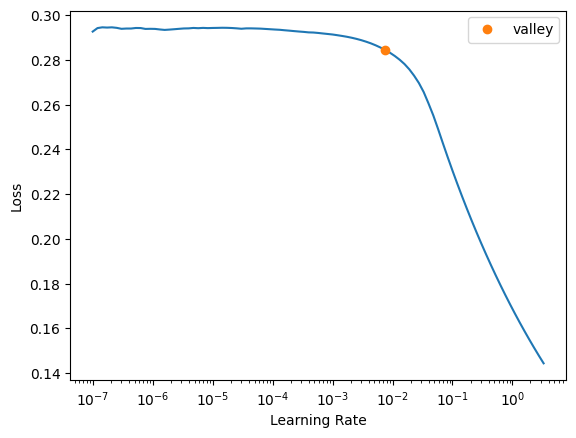

In [180]:
from fastai.vision.all import *

learn = collab_learner(dls, n_factors=50, y_range=(0, 1), use_nn=True, layers=[100, 50], loss_func=MSELossFlat())#BCEWithLogitsLossFlat layers=[200, 150, 100], 
optimal_lr = learn.lr_find()
print(optimal_lr)

In [181]:
# user_weights_before = learn.model.u_weight.weight.data.clone()
# item_weights_before = learn.model.i_weight.weight.data.clone()
# print("Initial User Weights:", user_weights_before[:5])
# print("Initial Item Weights:", item_weights_before[:5])

In [182]:
learn.fit_one_cycle(5, optimal_lr, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.000053,0.000035,00:13
1,0.000001,0.000001,00:19
2,0.000000,0.000000,00:22
3,0.000000,0.000000,00:25
4,0.000000,0.000000,00:21


In [183]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(8205, 249)
    (1): Embedding(9141, 264)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=513, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=0, high=1)
  )
)

In [184]:
# user_weights_after = learn.model.u_weight.weight.data
# item_weights_after = learn.model.i_weight.weight.data
# print("User Weights After Training:", user_weights_after[:5])
# print("Item Weights After Training:", item_weights_after[:5])

In [185]:
# import matplotlib.pyplot as plt

# user_embeddings = learn.model.embeds[0].weight.detach().cpu().numpy()
# item_embeddings = learn.model.embeds[1].weight.detach().cpu().numpy()

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(user_embeddings.flatten(), bins=50)
# plt.title('User Embeddings Distribution')

# plt.subplot(1, 2, 2)
# plt.hist(item_embeddings.flatten(), bins=50)
# plt.title('Item Embeddings Distribution')

# plt.show()

save model

In [189]:
learn.export("saved_models/user_collab_filtering_v2.pkl")

Model class

In [187]:
from typing import Dict, List


class UserCollabFilteringV2:
    def __init__(self):
        self.model = load_learner("saved_models/user_collab_filtering_v2.pkl")

    def get_recommendations(self, user_id: str = None, *args, **kwargs) -> List[int]:
        user_id = int(float(user_id))
        item_ids = dls.classes['shiur'].items[1:] # to avoid the na value
        item_ids = [int(item_id) for item_id in item_ids]
        user_tensor = torch.tensor([user_id] * len(item_ids)).unsqueeze(1)
        item_tensor = torch.tensor(item_ids).unsqueeze(1)
        input_tensor = torch.cat((user_tensor, item_tensor), dim=1)
        
        # Get predictions
        input_df = pd.DataFrame(input_tensor.numpy(), columns=['user', 'shiur'])
        user_item_dl = dls.test_dl(input_df)
        preds, _ = learn.get_preds(dl=user_item_dl)
        
        # Get top N recommendations
        top_n = kwargs.get('top_n', 10)
        top_indices = torch.argsort(preds, descending=True)[:top_n]
        top_item_ids = [item_ids[idx.item()] for idx in top_indices]
        return top_item_ids

    def get_weighted_recommendations(self, user_id: str = None, *args, **kwargs) -> Dict[int, float]:
        top_n = kwargs.get('top_n', 10)
        user_id = int(user_id)
        item_ids = dls.classes['shiur'].items[1:]
        item_ids = [int(item_id) for item_id in item_ids]
        user_tensor = torch.tensor([user_id] * len(item_ids)).unsqueeze(1)
        item_tensor = torch.tensor(item_ids).unsqueeze(1)
        input_tensor = torch.cat((user_tensor, item_tensor), dim=1)

        # Get predictions
        input_df = pd.DataFrame(input_tensor.numpy(), columns=['user', 'shiur'])
        user_item_dl = dls.test_dl(input_df)
        preds, _ = learn.get_preds(dl=user_item_dl)
        # preds = preds.numpy().flatten()

        # Get top N recommendations with their scores
        #top_indices = preds.argsort()[::-1][:top_n]
        top_indices = torch.argsort(preds, descending=True)[:top_n]
        top_item_ids = [item_ids[idx.item()] for idx in top_indices]
        top_scores = preds[top_indices].tolist()

        recommendations = {item_id: score for item_id, score in zip(top_item_ids, top_scores)}
        return recommendations

    def get_best_shiurim(self, shiur_num:int = 10): #based on highest bias
        shiur_bias = learn.model.i_bias.weight.squeeze()
        idxs = shiur_bias.argsort(descending=True)[:shiur_num]
        return [dls.classes['shiur'][i] for i in idxs]
    
    # def get_user_bias(self, user_id:str = None):
    #     user_biases = learn.model.u_bias.weight
    #     user_idx = learn.dls.classes['usbUserKey'].o2i[user_id]
    #     return user_biases[user_idx]
    
    # def get_shiur_bias(self, shiur_id:str = None):
    #     item_biases = learn.model.i_bias.weight
    #     item_idx = learn.dls.classes['usbUserKey'].o2i[shiur_id]
    #     return item_biases[item_idx]

Test model

In [188]:
testmodel = UserCollabFilteringV2()
#print(testmodel.get_best_shiurim())
print(testmodel.get_recommendations("24457"))
print(testmodel.get_weighted_recommendations("1083", top_n=10000))

[1000055, 1000055, 1000055, 1000055, 1000055, 1000055, 1000055, 1000055, 1000055, 1000055]


{1000055: [[0.999548614025116]]}
